# Gluon Dataset: Introduction to non-linear Regression using Tensorflow

## Source

https://github.com/rabah-khalek/TF_tutorials

## Learning Goals##
This notebook will serve as an introduction to the non-linear regression as well as the new extremely powerful TensorFlow library for Machine Learning (ML) from Google. We will also learn how to use the versatile Pandas package for handling data.


## Overview##
Throughout, we will work with the [Gluon dataset](https://github.com/rabah-khalek/TF_tutorials/tree/master/PseudoData). It computed using the [LHAPDF](https://lhapdf.hepforge.org) open source code, a general purpose C++ and python interpolator, used for evaluating PDFs from discretised data files.

Here is the description of the Gluon dataset we will be playing around with for this notebook:
>A gluon is an elementary particle that acts as the exchange particle (or gauge boson) for the strong force between quarks. It is analogous to the exchange of photons in the electromagnetic force between two charged particles. 

>In technical terms, gluons are vector gauge bosons that mediate strong interactions of quarks in quantum chromodynamics (QCD). Gluons themselves carry the color charge of the strong interaction. This is unlike the photon, which mediates the electromagnetic interaction but lacks an electric charge. Gluons therefore participate in the strong interaction in addition to mediating it, making QCD significantly harder to analyze than QED (quantum electrodynamics).

>Because of the inherent non-perturbative nature of partons(quarks and gluon in general) which cannot be observed as free particles, parton densities cannot be calculated using perturbative QCD.
Parton distribution functions are obtained by fitting observables to experimental data; they cannot be calculated using perturbative QCD.

> The parton density function $f_i(x,Q)$ gives the probability of finding in the proton a parton of flavour $i$ (quarks or gluon) carrying a fraction $x$ of the proton momentum with $Q$ being the energy scale of the hard interaction. Cross sections are calculated by convo- luting the parton level cross section with the PDFs. Since QCD does not predict the parton content of the proton, the shapes of the PDFs are determined by a fit to data from experimental observables in various processes, using the DGLAP evolution equation.

> This PseudoData is computed from such fit performed by the [NNPDF collaboration](http://nnpdf.mi.infn.it) that determines the structure of the proton using contemporary methods of artificial intelligence. NNPDF determines PDFs using as an unbiased modeling tool Neural Networks, trained using Genetic Algorithms and recently stochastic Gradient descent, and used to construct a Monte Carlo representation of PDFs and their uncertainties: a probability distribution in a space of functions.


## Importing the Gluon data set with Pandas

The dataset is a total of 1000 gluon PDF predictions computed between $x=[10^{-6},1]$ for $Q=2\,GeV$.  
<b> Exercise:</b> In what follows, use Pandas to import a random 800 x-points and call that the training data and import the rest 200 x-points and call that the test data.


In [1]:
# Importing the Gluon Data set
import sys, os
import pandas as pd
from sklearn.model_selection import train_test_split

import numpy as np
import warnings
#Commnet the next line on to turn off warnings
#warnings.filterwarnings('ignore')


seed=12
np.random.seed(seed)
import tensorflow as tf
# suppress tflow compilation warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

tf.set_random_seed(seed)

# Download the SUSY.csv (about 2GB) from UCI ML archive and save it in the same directory as this jupyter notebook
# See: https://archive.ics.uci.edu/ml/machine-learning-databases/00279/
#filename="SUSY.csv"
filename='PseudoData/gluon_NNPDF31_nlo_pch_as_0118.dat' 

lines_to_skip = 5

columns=["x", "gluon_cv", "gluon_sd"]
# Load 800 rows as train data, 200 as test data

df = pd.read_csv(filename, 
                 sep="\s+", 
                 skiprows=lines_to_skip, 
                 usecols=[0,1,2], 
                 names=columns)

df_train, df_test = train_test_split(df, test_size=0.2)

df_train = df_train.sort_values("x")
df_test = df_test.sort_values("x")

print("Data parsing is done!")


/Users/rabah/Documents/miniconda3/envs/tutorials/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/rabah/Documents/miniconda3/envs/tutorials/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/rabah/Documents/miniconda3/envs/tutorials/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Use

Data parsing is done!


## Building a Neural Network using TensorFlow##

Our NN consists of one input, one output and 1 hidden layer. We are using ReLU as activation function of the hidden layer and softmax for our output layer. As an additional bonus we will use Dropout — simple way to reduce overfitting during the training of our network. Let’s wrap our model in a little helper function:

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
import sys

def multilayer_perceptron(x, weights, biases, keep_prob):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_1 = tf.nn.dropout(layer_1, keep_prob)
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

def zscore(col):
    mean = 3.04
    std = 1.2
    return (col - mean)/std

Let’s set the number of neurons in the hidden layer to 10 and randomly initialize the weights and biases considering their proper dimensions:

In [33]:
n_hidden_1 = 5
n_input =  1 #df_train["x"].shape[0]
n_target =1 #df_train["gluon_cv"].shape[0]


weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, n_target]))}

biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'out': tf.Variable(tf.random_normal([n_target]))
}

keep_prob = tf.placeholder("float")



We will train our model for 5,000 epochs (training steps) with a batch size of 32. That is, at each step, we will train our NN using 32 rows of our data. Granted, in our case you can just train on the whole dataset. However, when the data is huge and you can’t fit it in memory, you would love to split it and feed it to the model at batches (chunks):

In [45]:
training_epochs = 5000
display_step = 1000

x = tf.placeholder("float", [None, 1])
y = tf.placeholder("float", [None, 1])
sigma = tf.placeholder("float", [None, 1])

N_train = len(df_train["x"])
N_test = len(df_test["x"])

#feature_name = "x"
#normalized_feature = tf.feature_column.numeric_column(
#  feature_name,
#  normalizer_fn=zscore)

predictions = multilayer_perceptron(x, weights, biases, keep_prob)

cost = tf.reduce_mean(tf.square(predictions-y)/sigma)

optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(cost)

train_x = np.array(df_train["x"]).reshape(N_train,1)
train_y = np.array(df_train["gluon_cv"]).reshape(N_train,1)
train_sigma = np.array(df_train["gluon_sd"]).reshape(N_train,1)

test_x = np.array(df_test["x"]).reshape(N_test,1)
test_y = np.array(df_test["gluon_cv"]).reshape(N_test,1)
test_sigma = np.array(df_test["gluon_sd"]).reshape(N_test,1)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    avg_cost = 0.0
    for epoch in range(training_epochs):

        _, c = sess.run([optimizer, cost], 
                        feed_dict={
                            x: train_x, 
                            y: train_y, 
                            sigma: train_sigma,
                            keep_prob: 1
                        })
        avg_cost += c/N_train
        
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(avg_cost))
    print("Optimization Finished!")
    predictions_values = sess.run(predictions, 
                        feed_dict={
                            x: train_x, 
                            y: train_y,
                            keep_prob: 0.8
                        })
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({x: test_x, y: test_y, sigma: test_sigma, keep_prob: 1.0}))
 


Epoch: 0001 cost= 0.023078671
Epoch: 1001 cost= 1.254094338
Epoch: 2001 cost= 2.095564117
Epoch: 3001 cost= 2.821723006
Epoch: 4001 cost= 3.466154348
Optimization Finished!
Accuracy: 1.0


## Plotting output


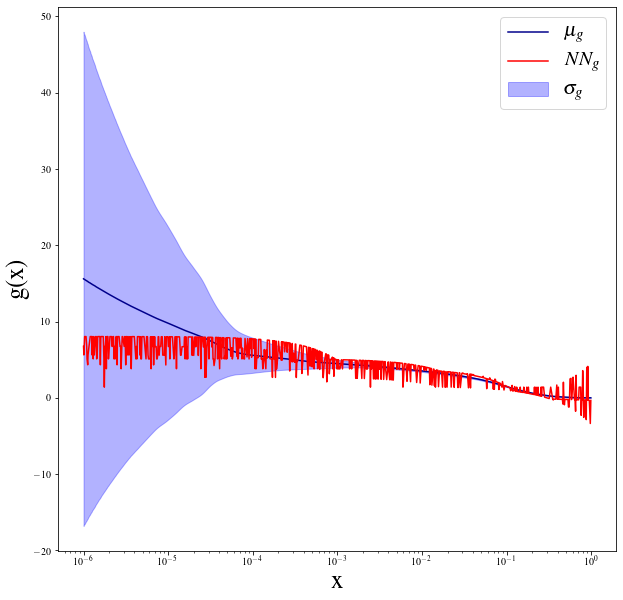

In [46]:
#predictions = np.array(predictions_values.eval(session=tf.Session()))

plt.figure(figsize=(10,10))
ax = plt.subplot(111)
ax.plot(df_train["x"],df_train["gluon_cv"],color='darkblue',label='$\mu_{g}$')
ax.plot(df_train["x"],predictions_values,color='red',label='$NN_{g}$')
ax.fill_between(df_train["x"],df_train["gluon_cv"]+df_train["gluon_sd"],
                df_train["gluon_cv"]-df_train["gluon_sd"] ,color='blue', 
                alpha=0.3, label='$\sigma_{g}$')
#df_train.plot(kind='line',x='x',y=['gluon_cv'], yerr='gluon_sd',color=['red'], ax=ax)
ax.set_xscale('log')
ax.set_ylabel(r'g(x)',fontsize=25)
ax.set_xlabel(r'x',fontsize=25)
ax.legend(loc='best',fontsize=20)
plt.show()